## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='iris_report/tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'iris_report/tree.dot', '-o', 'iris_report/tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'iris_report/tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [2]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer #Enables IterativeImputer
from sklearn.impute import IterativeImputer #A strategy for imputing missing values by modeling each feature with 
#missing values as a function of other features in a round-robin fashion.
from sklearn.ensemble import ExtraTreesRegressor #This class implements a meta estimator that fits a number of 
#randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve 
#the predictive accuracy and control over-fitting.

In [3]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

patient_id  global_num     sex  birth_year  age country province  \
0  1000000001         2.0    male      1964.0  50s   Korea    Seoul   
1  1000000002         5.0    male      1987.0  30s   Korea    Seoul   
2  1000000003         6.0    male      1964.0  50s   Korea    Seoul   
3  1000000004         7.0    male      1991.0  20s   Korea    Seoul   
4  1000000005         9.0  female      1992.0  20s   Korea    Seoul   

          city disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu     NaN       overseas inflow              1.0           NaN   
1  Jungnang-gu     NaN       overseas inflow              1.0           NaN   
2    Jongno-gu     NaN  contact with patient              2.0  2.002000e+09   
3      Mapo-gu     NaN       overseas inflow              1.0           NaN   
4  Seongbuk-gu     NaN  contact with patient              2.0  1.000000e+09   

   contact_number symptom_onset_date confirmed_date released_date  \
0            75.0         2020-01-22     2020-01-23    2020-02-05   
1            31.0                NaN     2020-01-30    2020-03-02   
2            17.0                NaN     2020-01-30    2020-02-19   
3             9.0         2020-01-26     2020-01-30    2020-02-15   
4             2.0                NaN     2020-01-31    2020-02-24   

  deceased_date     state  
0           NaN  released  
1           NaN  released  
2           NaN  released  
3           NaN  released  
4           NaN  released

In [4]:
df.shape

(2218, 18)

In [5]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

VarName  NullCount
0              disease       2199
1        deceased_date       2186
2      infection_order       2176
3   symptom_onset_date       2025
4        released_date       1995
5       contact_number       1807
6          infected_by       1749
7       infection_case       1055
8           global_num        904
9           birth_year        454
10                 age        261
11                 sex        145
12      confirmed_date        141
13               state         88
14                city         65

In [6]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [7]:
df['n_age'] = int(datetime.today().strftime('%Y')) - df['birth_year']

In [8]:
df.head()

patient_id  global_num     sex  birth_year  age country province  \
0  1000000001         2.0    male      1964.0  50s   Korea    Seoul   
1  1000000002         5.0    male      1987.0  30s   Korea    Seoul   
2  1000000003         6.0    male      1964.0  50s   Korea    Seoul   
3  1000000004         7.0    male      1991.0  20s   Korea    Seoul   
4  1000000005         9.0  female      1992.0  20s   Korea    Seoul   

          city disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu     NaN       overseas inflow              1.0           NaN   
1  Jungnang-gu     NaN       overseas inflow              1.0           NaN   
2    Jongno-gu     NaN  contact with patient              2.0  2.002000e+09   
3      Mapo-gu     NaN       overseas inflow              1.0           NaN   
4  Seongbuk-gu     NaN  contact with patient              2.0  1.000000e+09   

   contact_number symptom_onset_date confirmed_date released_date  \
0            75.0         2020-01-22     2020-01-23    2020-02-05   
1            31.0                NaN     2020-01-30    2020-03-02   
2            17.0                NaN     2020-01-30    2020-02-19   
3             9.0         2020-01-26     2020-01-30    2020-02-15   
4             2.0                NaN     2020-01-31    2020-02-24   

  deceased_date     state  n_age  
0           NaN  released   57.0  
1           NaN  released   34.0  
2           NaN  released   57.0  
3           NaN  released   30.0  
4           NaN  released   29.0

### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [9]:
df.isnull().sum().sort_values(ascending=False)

disease               2199
deceased_date         2186
infection_order       2176
symptom_onset_date    2025
released_date         1995
contact_number        1807
infected_by           1749
infection_case        1055
global_num             904
birth_year             454
n_age                  454
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
province                 0
country                  0
patient_id               0
dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [11]:
#replace all null values with 0
df['disease'].fillna(0, inplace=True)
#convert True to 1 with changing the type
df['disease'] = df['disease'].astype(int)

In [12]:
df['disease'].unique()

array([0, 1])

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [13]:
df['global_num'].fillna(np.mean(df['global_num']), inplace = True)
df['birth_year'].fillna(np.mean(df['birth_year']), inplace = True)
df['infection_order'].fillna(np.mean(df['infection_order']), inplace = True)
df['infected_by'].fillna(np.mean(df['infected_by']), inplace = True)
df['contact_number'].fillna(np.mean(df['contact_number']), inplace = True)

 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [14]:
df.isnull().sum().sort_values(ascending=False)

deceased_date         2186
symptom_onset_date    2025
released_date         1995
infection_case        1055
n_age                  454
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
contact_number           0
infected_by              0
infection_order          0
disease                  0
province                 0
country                  0
birth_year               0
global_num               0
patient_id               0
dtype: int64

 **<font color='teal'> Check for any remaining null values.</font>**

In [15]:
#infection_case : this feature includes 16 unique values and the top one is 'contact with patient', looks like it is
#reasonable to replace null with this value.
most_infection_case = df['infection_case'].value_counts().sort_values(ascending=False).index[0]
df['infection_case'].fillna(most_infection_case, inplace=True)

In [16]:
#n_age : The average value of this column is 46 years old which is a good replacement for null values in this column
df['n_age'].fillna(np.mean(df['n_age']), inplace=True)

In [17]:
#age : all the missing values of this column will be input based on the coresponding value in the n_age column
df['age'] = ((df['n_age']//10).astype('int').astype('str'))+'0s'

In [18]:
#sex : this dataset includes 1171 females and 902 males and 145 null values in 'sex' column. The average 'n_age' of 
#female records are 47.64, male records are 43.90, and when 'sex' is null the average 'n_age' is 46.01, therefore I 
#am going to assume the 'sex' of the missing values are 'female'
# df['sex'].value_counts() >> (female    1171), (male       902)
# df['sex'].isnull().sum() >> 145
# np.mean(df['n_age'][df['sex'].isnull()]) >> 46.01133786848088
# np.mean(df['n_age'][df['sex']=='male']) >> 43.89767259453679
# np.mean(df['n_age'][df['sex']=='female']) >> 47.6394557823132
df['sex'].fillna('female', inplace=True)

Remove date columns from the data.


In [19]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [20]:
#city : Less than 3% (65/2218) of the cities has null values, so we can just drop these rows in favor of saving 
#some times
df.dropna(subset=['city'], inplace=True)

In [21]:
df.isnull().sum().sort_values(ascending=False)

state              88
n_age               0
contact_number      0
infected_by         0
infection_order     0
infection_case      0
disease             0
city                0
province            0
country             0
age                 0
birth_year          0
sex                 0
global_num          0
patient_id          0
dtype: int64

In [22]:
#state : this feature needs to be predict so the null values won't fix at this stage.
unknown_state = df.state.isnull().sum()
known_state = df.state.notnull().sum()
print('This problem is trying to predict {} states, using {} known state as training data.'.
      format(unknown_state, known_state))

This problem is trying to predict 88 states, using 2065 known state as training data.


Review the count of unique values by column.

In [23]:
print(df.nunique())

patient_id         2153
global_num         1245
sex                   2
birth_year           97
age                  11
country               4
province             16
city                134
disease               2
infection_case       16
infection_order       7
infected_by         201
contact_number       65
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [24]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.578263
sex                0.000929
birth_year         0.045053
age                0.005109
country            0.001858
province           0.007431
city               0.062239
disease            0.000929
infection_case     0.007431
infection_order    0.003251
infected_by        0.093358
contact_number     0.030190
state              0.001393
n_age              0.045053
dtype: float64


Review the range of values per column.

In [25]:
df.describe().T

count          mean           std           min  \
patient_id       2153.0  4.090226e+09  2.172408e+09  1.000000e+09   
global_num       2153.0  4.745634e+03  2.153605e+03  1.000000e+00   
birth_year       2153.0  1.975337e+03  1.724105e+01  1.916000e+03   
disease          2153.0  4.644682e-03  6.800924e-02  0.000000e+00   
infection_order  2153.0  2.285714e+00  1.732204e-01  1.000000e+00   
infected_by      2153.0  2.611896e+09  7.222042e+08  1.000000e+09   
contact_number   2153.0  2.306565e+01  2.796573e+01  0.000000e+00   
n_age            2153.0  4.566322e+01  1.724105e+01  1.000000e+00   

                          25%           50%           75%           max  
patient_id       2.000000e+09  6.001000e+09  6.004000e+09  7.000000e+09  
global_num       4.664817e+03  4.664817e+03  5.989000e+03  8.717000e+03  
birth_year       1.965000e+03  1.974989e+03  1.989000e+03  2.020000e+03  
disease          0.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00  
infection_order  2.285714e+00  2.285714e+00  2.285714e+00  6.000000e+00  
infected_by      2.600789e+09  2.600789e+09  2.600789e+09  6.113000e+09  
contact_number   2.412895e+01  2.412895e+01  2.412895e+01  1.091000e+03  
n_age            3.200000e+01  4.601134e+01  5.600000e+01  1.050000e+02

### Check for duplicated rows

In [26]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

Empty DataFrame
Columns: [patient_id, global_num, sex, birth_year, age, country, province, city, disease, infection_case, infection_order, infected_by, contact_number, state, n_age]
Index: []

Print the categorical columns and their associated levels.

In [27]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape

(2153, 7)

In [28]:
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

VarName  LevelsCount
0             sex            2
1             age           11
2         country            4
3        province           16
4            city          134
5  infection_case           16
6           state            3

**<font color='teal'> Plot the correlation heat map for the features.</font>**

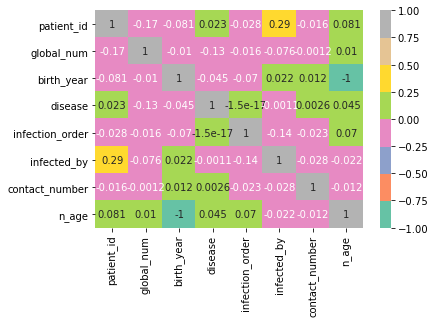

In [29]:
df_correlation = df.corr()
sns.heatmap(df_correlation, cmap='Set2', annot=True)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

In [30]:
df.columns

Index(['patient_id', 'global_num', 'sex', 'birth_year', 'age', 'country',
       'province', 'city', 'disease', 'infection_case', 'infection_order',
       'infected_by', 'contact_number', 'state', 'n_age'],
      dtype='object')

In [31]:
df.head()

patient_id  global_num     sex  birth_year  age country province  \
0  1000000001         2.0    male      1964.0  50s   Korea    Seoul   
1  1000000002         5.0    male      1987.0  30s   Korea    Seoul   
2  1000000003         6.0    male      1964.0  50s   Korea    Seoul   
3  1000000004         7.0    male      1991.0  30s   Korea    Seoul   
4  1000000005         9.0  female      1992.0  20s   Korea    Seoul   

          city  disease        infection_case  infection_order   infected_by  \
0   Gangseo-gu        0       overseas inflow              1.0  2.600789e+09   
1  Jungnang-gu        0       overseas inflow              1.0  2.600789e+09   
2    Jongno-gu        0  contact with patient              2.0  2.002000e+09   
3      Mapo-gu        0       overseas inflow              1.0  2.600789e+09   
4  Seongbuk-gu        0  contact with patient              2.0  1.000000e+09   

   contact_number     state  n_age  
0            75.0  released   57.0  
1            31.0  released   34.0  
2            17.0  released   57.0  
3             9.0  released   30.0  
4             2.0  released   29.0

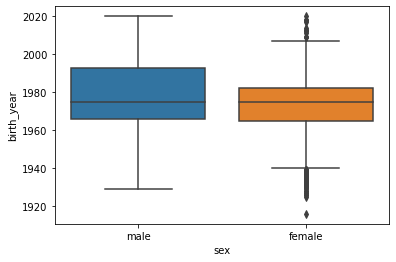

In [32]:
sns.boxplot(x='sex', y='birth_year', data=df)

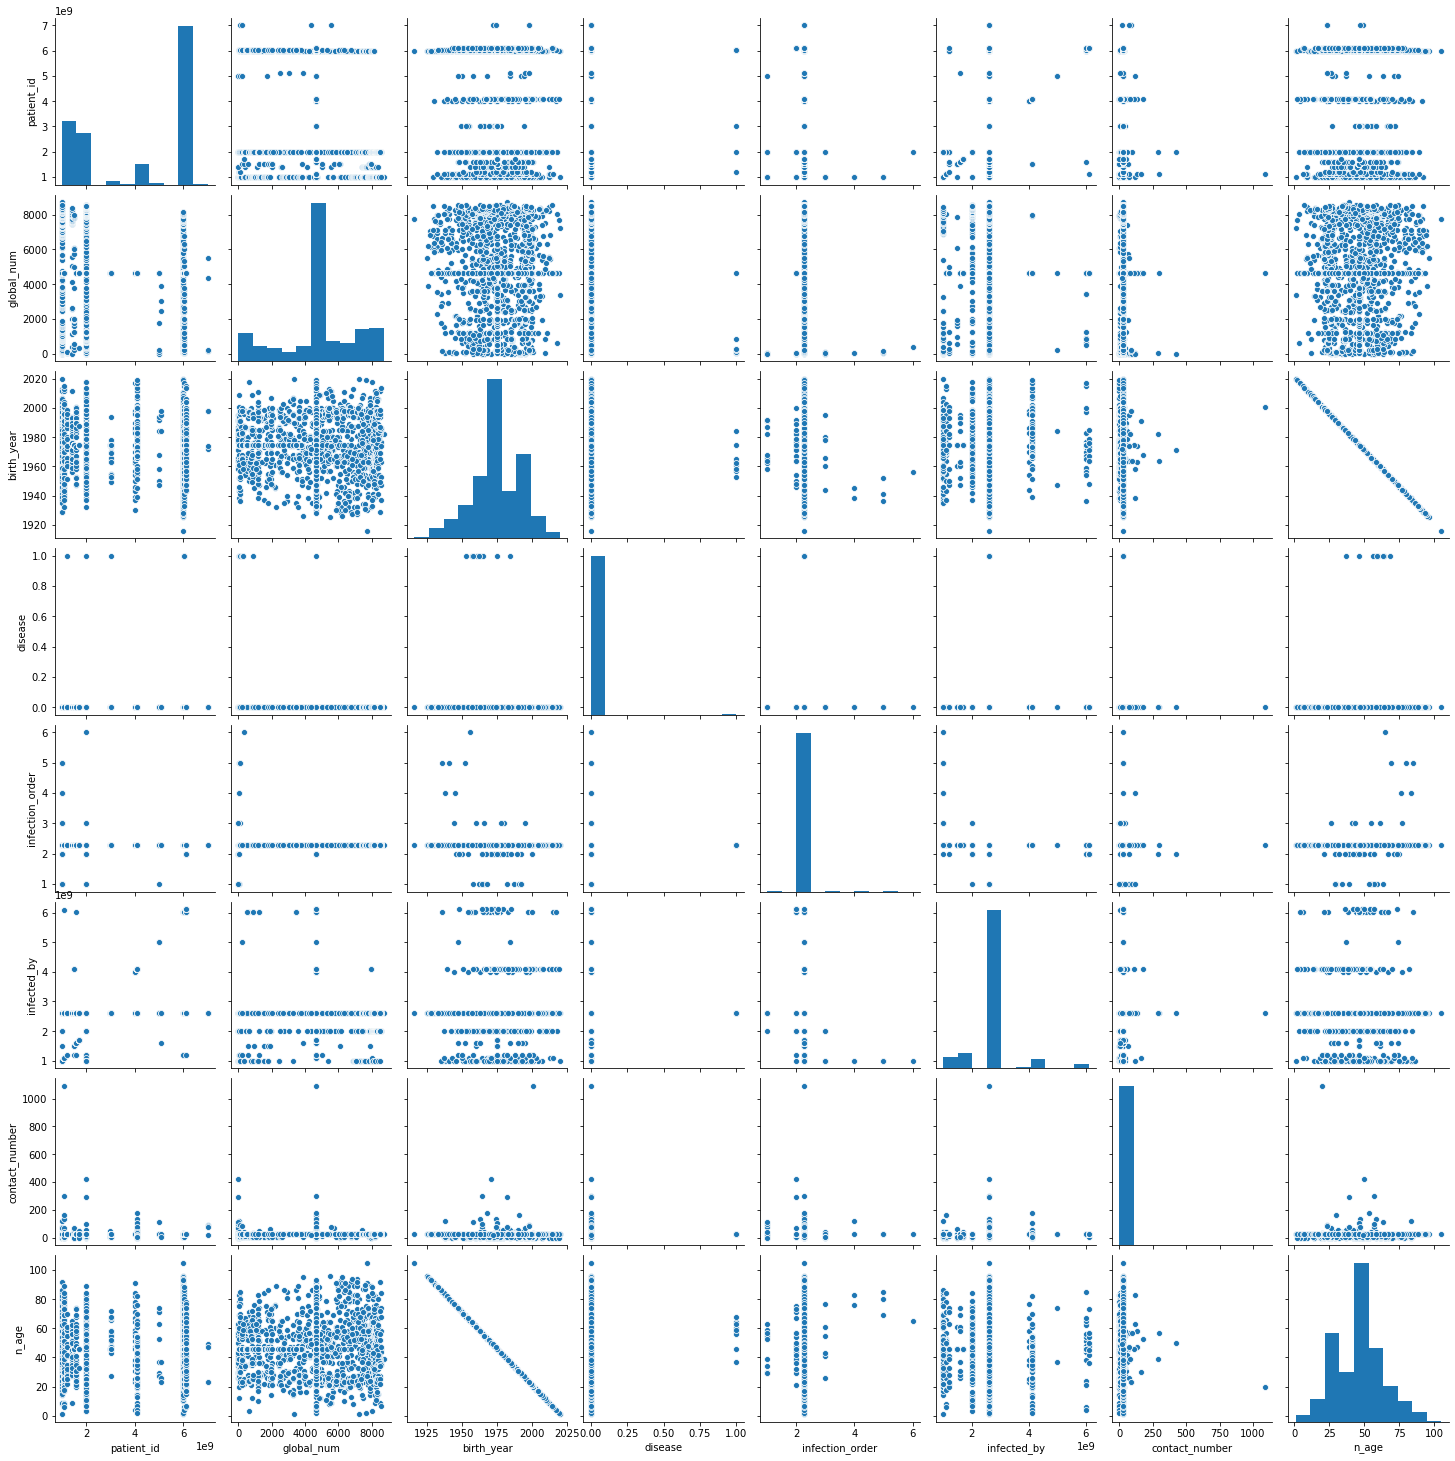

In [33]:
sns.pairplot(df)

**<font color='teal'> Create dummy features for object type features. </font>**

In [34]:
categorical_features = ['sex', 'country', 'infection_case']
df_dummies = pd.get_dummies(df[categorical_features])

In [35]:
col_dummies = pd.get_dummies(df[categorical_features]).columns

In [36]:
df[col_dummies] = df_dummies

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 0 to 2217
Data columns (total 37 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   patient_id                                       2153 non-null   int64  
 1   global_num                                       2153 non-null   float64
 2   sex                                              2153 non-null   object 
 3   birth_year                                       2153 non-null   float64
 4   age                                              2153 non-null   object 
 5   country                                          2153 non-null   object 
 6   province                                         2153 non-null   object 
 7   city                                             2153 non-null   object 
 8   disease                                          2153 non-null   int64  
 9   infection_case                

In [38]:
df = df.drop(columns=categorical_features)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2153 entries, 0 to 2217
Data columns (total 34 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   patient_id                                       2153 non-null   int64  
 1   global_num                                       2153 non-null   float64
 2   birth_year                                       2153 non-null   float64
 3   age                                              2153 non-null   object 
 4   province                                         2153 non-null   object 
 5   city                                             2153 non-null   object 
 6   disease                                          2153 non-null   int64  
 7   infection_order                                  2153 non-null   float64
 8   infected_by                                      2153 non-null   float64
 9   contact_number                

### Split the data into test and train subsamples

In [40]:
# first I set aside thoes records with no states for the final prediction:
pred_dataset = df[df.state.isnull()]

In [41]:
pred_dataset.shape

(88, 34)

In [42]:
# then set the other part of dataset with known state value, to build our model
clean_dataset = df[df.state.notnull()]

In [43]:
clean_dataset.shape

(2065, 34)

In [44]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

#we already have the birth_year column so I think we can drop age, also columns city and province are not accurate 
#enough, so I am going to drop these two columns and just keep the country column which already has been changed as 
#a dummy column (these three columns are string and if I keep them it will return error during scaling process).

y = clean_dataset['state']
X = clean_dataset.drop(columns=['state', 'age', 'city', 'province'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [45]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [46]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [47]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1, n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.867
Random Forest: f1-score=0.843


In [48]:
#know I apply this model to predict state from pred_dataset:
newX = pred_dataset.drop(columns=['state', 'age', 'city', 'province'])

scaler = preprocessing.StandardScaler().fit(newX)
newX_scaled=scaler.transform(newX)

pred_dataset['state'] = model_res.predict(newX_scaled)

pred_dataset['state']

<ipython-input-48-d58c60f5b84a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_dataset['state'] = model_res.predict(newX_scaled)


802     isolated
803     isolated
804     isolated
805     isolated
806     isolated
          ...   
885     isolated
886     isolated
887     released
888     released
2213    isolated
Name: state, Length: 88, dtype: object

In [49]:
pred_dataset['state'].value_counts()

isolated    82
released     6
Name: state, dtype: int64

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [50]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[  3   2   0]
 [  0 340   9]
 [  0  44  15]]
Normalized confusion matrix
[[0.6  0.4  0.  ]
 [0.   0.97 0.03]
 [0.   0.75 0.25]]


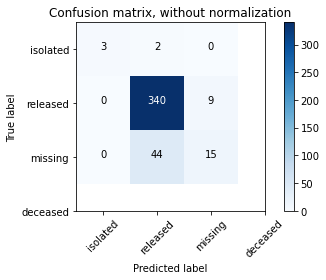

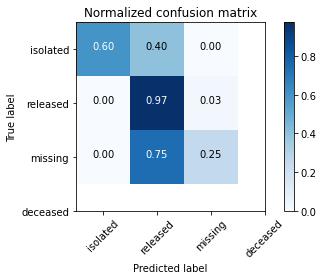

In [51]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


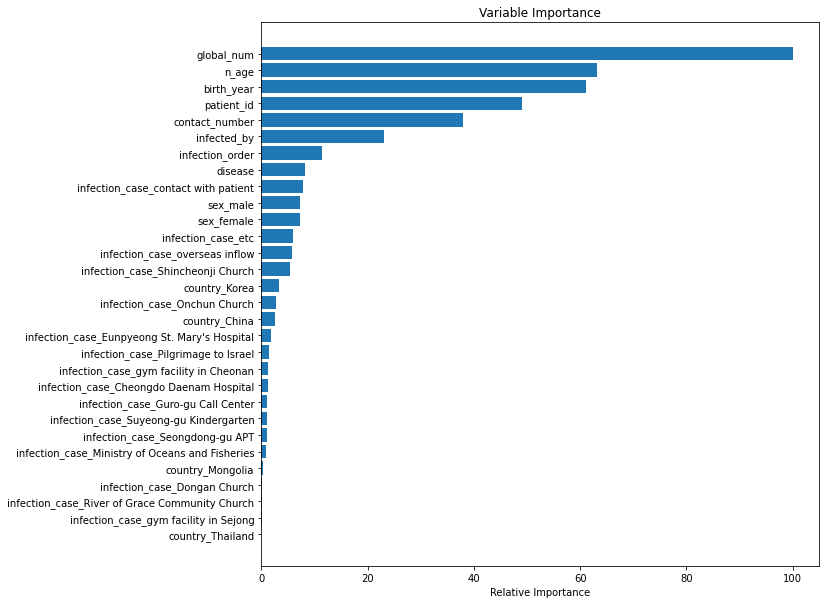

In [52]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.